In [92]:
import io
import cv2

import numpy as np
import random 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from datetime import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [93]:
df = pd.read_csv('data.csv')
df = df.drop(columns=['Open', 'Low', 'High'])
df = df.set_index('Date')
df

,Close,PE_CAPE
Date,,
1960-01-04,59.910000,18.338285
1960-01-05,60.389999,18.338285
1960-01-06,60.130001,18.338285
1960-01-07,59.689999,18.338285
1960-01-08,59.500000,18.338285
...,...,...
2021-12-27,4791.190000,38.660000
2021-12-28,4786.350000,38.660000
2021-12-29,4793.060000,38.660000


In [94]:
date = df.index.to_numpy()
close = df['Close'].to_numpy()
pe = df['PE_CAPE'].to_numpy()
close_lag = []
pe_lag = []
r = []
for i in range(180, len(close)):
    x = close[i-180:i]
    y = pe[i-180:i]
    close_lag.append(x)
    pe_lag.append(y)
    r.append(pearsonr(x, y)[0])
close_lag = np.array(close_lag)
pe_lag = np.array(pe_lag)
r = np.array(r)
close_value = close[180:]
pe_value = pe[180:]

In [95]:
from scipy.signal import argrelextrema
time = ['1960-01-01']
money = [1]
i = 0
while i < len(close_value):
    if r[i] > 0.9 and pe_lag[i,0] < pe_lag[i,-1]:
        buy = close_lag[i, argrelextrema(close_lag[i,:], np.less)[0][0]]
        sell = close_value[i]
        money.append(money[-1] * sell / buy)
        time.append(date[180+i])
        i += 180
    else:
        i += 1

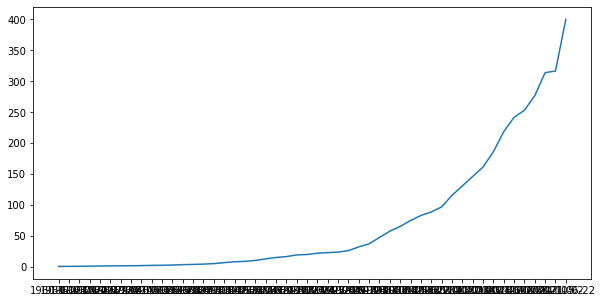

In [96]:
plt.figure(figsize=(10,5))
plt.plot(time, money)

In [97]:
v = 0
prn = set()
while v < len(close_value):
    mini = argrelextrema(close_lag[v,:], np.less)[0]
    maxi = argrelextrema(close_lag[v,:], np.greater)[0]
    i = 0; j = 1; k = 0
    while j < len(maxi) and k < len(mini):
        if mini[k] < maxi[j]:
            k += 1
            continue
        if close_lag[v, maxi[i]] < close_lag[v, maxi[j]] and close_lag[v, maxi[j]] < close_lag[v, maxi[-1]]:
            # diff within 1%
            if abs(close_lag[v, maxi[i]] - close_lag[v, mini[k]]) < 0.01 * close_lag[v, maxi[i]]:
                prn.add(v)
        i += 1
        j += 1
    v += 1

In [98]:
abcd = []
for v in prn:    
    if r[v] > 0.9 and close_lag[v,-1] == np.max(close_lag[v,:]):
        abcd.append(v)
len(abcd)

980

In [99]:
v = 0
rprn = set()
while v < len(close_value):
    mini = argrelextrema(close_lag[v,:], np.less)[0]
    maxi = argrelextrema(close_lag[v,:], np.greater)[0]
    i = 1; j = 0; k = 0
    while i < len(maxi) and k < len(mini):
        if maxi[j] < mini[k]:
            i += 1
            j += 1
            continue
        if close_lag[v, maxi[i]] < close_lag[v, maxi[j]] and close_lag[v, maxi[j]] < close_lag[v, maxi[0]]:
            # diff within 1%
            if abs(close_lag[v, maxi[i]] - close_lag[v, mini[k]]) < 0.01 * close_lag[v, maxi[i]]:
                rprn.add(v)
        k += 1
    v += 1

In [100]:
dcba = []
for v in rprn:    
    if r[v] > 0.9 and close_lag[v,-1] == np.min(close_lag[v,:]):
        dcba.append(v)
len(dcba)

153

In [101]:
oos = list(set([i for i in range(len(close_value))]) - prn - rprn)

In [102]:
s = prn - set(abcd) | rprn - set(dcba)
for v in s:    
    if r[v] < 0.5:
        oos.append(v)
len(oos)

965

In [103]:
# def fig2img(fig, dpi=180):
#     buf = io.BytesIO()
#     fig.savefig(buf, format="png", dpi=dpi)
#     buf.seek(0)
#     img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
#     buf.close()
#     img = cv2.imdecode(img_arr, 1)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = cv2.resize(img,(50,50),interpolation = cv2.INTER_AREA).astype(np.uint8)

#     return img

# data = []
# plt.figure(figsize=(5,5))
# for i in abcd:
#     fig = plt.gcf()
#     plt.plot(range(180), close_lag[i,:])
#     plt.axis('off');
#     data.append(fig2img(fig).flatten())
#     plt.clf()
# for i in dcba:
#     fig = plt.gcf()
#     plt.plot(range(180), close_lag[i,:])
#     plt.axis('off');
#     data.append(fig2img(fig).flatten())
#     plt.clf()
# for i in oos:
#     fig = plt.gcf()
#     plt.plot(range(180), close_lag[i,:])
#     plt.axis('off');
#     data.append(fig2img(fig).flatten())
#     plt.clf()
# data = np.array(data)
# labels = np.array([0]*len(abcd) + [1]*len(dcba) + [2]*len(oos))
# np.save('data', data)
# np.save('labels', labels)

<Figure size 360x360 with 0 Axes>

In [106]:
data = np.load('img_data.npy')
labels = np.load('img_labels.npy')

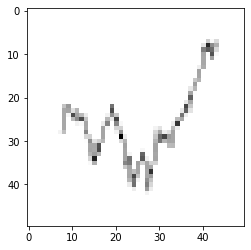